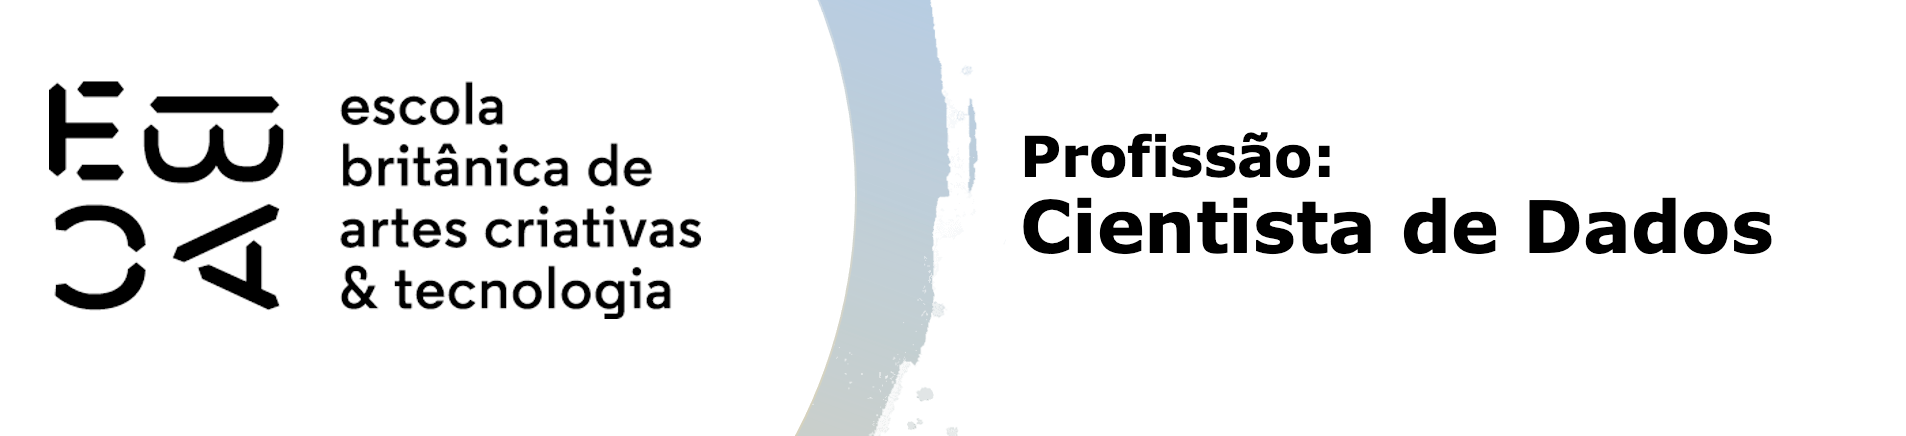

# Regressão III - Tarefa

In [139]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.nonparametric.api as nparam
import statsmodels.formula.api as smf

from scipy.interpolate import interp1d

from segmented import segmented

In [140]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [141]:
# Verificando valores faltantes
df.isna().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [142]:
# Substituindo pela média
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace = True)
df.isna().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [143]:
# removendo o indice, para o data_ref deixar de ser o indice
df.reset_index(inplace=True)
df.head(3)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66


In [144]:
# Transformando o data_ref no tipo data para poder trabalhar melhor com essa coluna
df['data_ref'] = pd.to_datetime(df['data_ref'])
df['data_ref'].dtypes

dtype('<M8[ns]')

In [145]:
# Guardando valor da ultima data
ultima_data = df['data_ref'].max()

# Criando novo DataFrame contendo apenas os ultimos 3 meses
# Filtra o data_ref com a ultima data menos 3 meses
df_ultimo_3_meses = df[df['data_ref'] >= ultima_data - pd.DateOffset(months=3)]
df_ultimo_3_meses

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
550000,2015-12-01,14180,F,S,N,0,Assalariado,Superior completo,Casado,Casa,56,20.887671,2.0,28655.39
550001,2015-12-01,14159,F,S,N,0,Assalariado,Superior completo,Casado,Casa,28,9.460274,2.0,3241.54
550002,2015-12-01,4366,M,S,S,3,Assalariado,Médio,Casado,Casa,38,2.257534,5.0,1587.26
550003,2015-12-01,3799,F,S,S,0,Pensionista,Médio,Casado,Casa,61,7.746165,2.0,3406.36
550004,2015-12-01,9437,F,N,N,0,Assalariado,Médio,Casado,Casa,51,9.936986,2.0,6323.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
749996,2016-03-01,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,7.746165,2.0,4084.37
749997,2016-03-01,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66
749998,2016-03-01,3024,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49


### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [146]:
# Removendo as colunas index e data_ref
df_ultimo_3_meses = df_ultimo_3_meses.drop(['index', 'data_ref'], axis = 1).reset_index(drop = True)
df_ultimo_3_meses

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,F,S,N,0,Assalariado,Superior completo,Casado,Casa,56,20.887671,2.0,28655.39
1,F,S,N,0,Assalariado,Superior completo,Casado,Casa,28,9.460274,2.0,3241.54
2,M,S,S,3,Assalariado,Médio,Casado,Casa,38,2.257534,5.0,1587.26
3,F,S,S,0,Pensionista,Médio,Casado,Casa,61,7.746165,2.0,3406.36
4,F,N,N,0,Assalariado,Médio,Casado,Casa,51,9.936986,2.0,6323.71
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
199996,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,7.746165,2.0,4084.37
199997,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66
199998,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49


In [147]:
# Verificando o tipo das variáveis para aplicar one-hot encoding
df_ultimo_3_meses.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
dtype: object

In [148]:
# Separando as colunas categóricas para aplicar o one-hot encoding apenas nessas variáveis
categoricas = df_ultimo_3_meses.select_dtypes(include = ['object']).columns
categoricas

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

In [149]:
# Transformando em dummies as variáveis categóricas
df_ultimo_3_meses = pd.get_dummies(df_ultimo_3_meses, columns = categoricas)
df_ultimo_3_meses

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,posse_de_imovel_N,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,56,20.887671,2.0,28655.39,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,0,28,9.460274,2.0,3241.54,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,3,38,2.257534,5.0,1587.26,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,61,7.746165,2.0,3406.36,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,51,9.936986,2.0,6323.71,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1,29,8.665753,3.0,2930.40,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
199996,0,65,7.746165,2.0,4084.37,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
199997,0,33,10.969863,2.0,4339.66,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
199998,1,28,8.219178,3.0,9159.49,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


In [150]:
# Separando os valores da variável resposta e das variáveis explicativas
y = df_ultimo_3_meses['renda']
X = df_ultimo_3_meses.drop(columns=['renda'])

# Criando modelo de regressão
modelo = sm.OLS(y, sm.add_constant(X))
# Treinando modelo
resultado = modelo.fit()

# Obtendo o valor de R Ajustado
r_quadrado_ajustado = resultado.rsquared_adj
r_quadrado_ajustado

0.3021804381923764

In [151]:
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     3610.
Date:                Thu, 29 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:22:52   Log-Likelihood:            -2.2969e+06
No. Observations:              200000   AIC:                         4.594e+06
Df Residuals:                  199975   BIC:                         4.594e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [152]:
# Separando o tempo emprego em 20 quantis
# incluido o duplicates = drop pois estava dando um erro na divisão dos quantis
df_analise_ultimo_3_meses = df_ultimo_3_meses
df_analise_ultimo_3_meses['quantis_tempo_emprego'] = pd.qcut(df_ultimo_3_meses['tempo_emprego'], q = 20, duplicates = 'drop')
df_analise_ultimo_3_meses

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,posse_de_imovel_N,...,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental,quantis_tempo_emprego
0,0,56,20.887671,2.0,28655.39,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,"(20.189, 42.907]"
1,0,28,9.460274,2.0,3241.54,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,"(9.093, 10.458]"
2,3,38,2.257534,5.0,1587.26,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,"(2.106, 2.912]"
3,0,61,7.746165,2.0,3406.36,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,"(7.474, 7.746]"
4,0,51,9.936986,2.0,6323.71,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,"(9.093, 10.458]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1,29,8.665753,3.0,2930.40,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,"(8.123, 9.093]"
199996,0,65,7.746165,2.0,4084.37,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,"(7.474, 7.746]"
199997,0,33,10.969863,2.0,4339.66,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,"(10.458, 12.46]"
199998,1,28,8.219178,3.0,9159.49,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,"(8.123, 9.093]"


In [153]:
# Criando novo DataFrame onde as linhas são os quantis e as colunas são as informações pedidas no exercício
df_analise_ultimo_3_meses = df_ultimo_3_meses.groupby('quantis_tempo_emprego').agg({
    'quantis_tempo_emprego': 'count', # Contagem de observações em cada quantil
    'renda': lambda x: np.log(x.mean()), # Média do log da renda
    'tempo_emprego': 'mean' # Média do tempo de emprego
})

# Mudando o nome das colunas
df_analise_ultimo_3_meses.columns = ['q_observacao', 'media_log_renda', 'tempo_medio']
df_analise_ultimo_3_meses

,q_observacao,media_log_renda,tempo_medio
quantis_tempo_emprego,,,
"(0.11699999999999999, 0.827]",10146,7.615341,0.521711
"(0.827, 1.468]",9948,7.721873,1.134223
"(1.468, 2.106]",9906,7.825659,1.791140
"(2.106, 2.912]",10018,7.920031,2.513849
"(2.912, 3.636]",10061,8.023818,3.300750
"(3.636, 4.301]",9957,8.124970,3.988797
"(4.301, 4.937]",9987,8.186268,4.617357
"(4.937, 5.759]",10022,8.291892,5.369558
"(5.759, 6.622]",10021,8.374893,6.202152


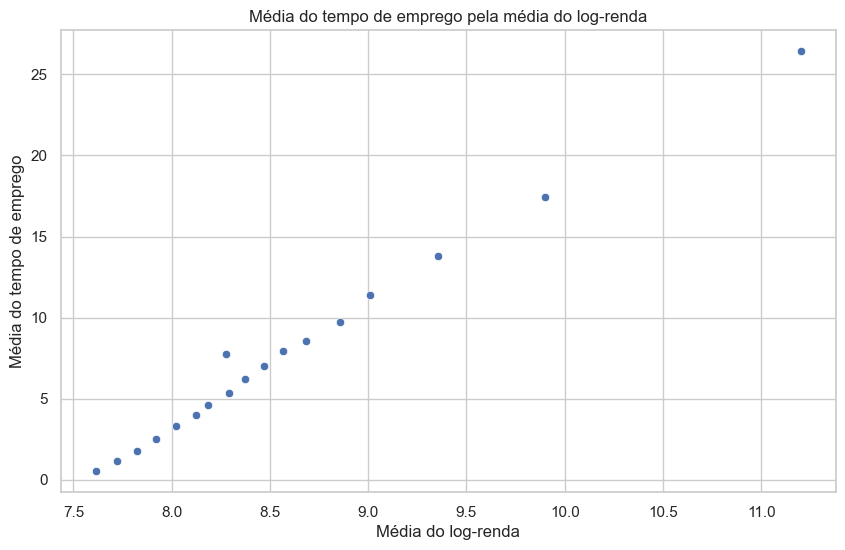

In [154]:
# Estilo do Seaborn
sns.set(style="whitegrid")

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_analise_ultimo_3_meses, x = 'media_log_renda', y = 'tempo_medio')

# Adicionar título e rótulos
plt.title('Média do tempo de emprego pela média do log-renda')
plt.xlabel('Média do log-renda')
plt.ylabel('Média do tempo de emprego')

# Exibir o gráfico
plt.show()

#### O gráfico sugeriu praticamente uma reta com uma leve ondulação, o Lowess parece que faria um bom trabalho, a transformação também, porém tem que ser levado em conta que os dados já estão transformados em Log e além disso já foi visto em módulos anteriores a transformação de dados.

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


### Lowess com Log

In [155]:
# Criando novos X e y partindo do ultimo DataFrame criado
y = df_analise_ultimo_3_meses['media_log_renda']
X = df_analise_ultimo_3_meses.drop(columns=['media_log_renda'])

In [156]:
# Selecionando uma variável para usar no lowess
X_selected = X['tempo_medio']
# Criando o lowess com fracionamento padrão
lowess = sm.nonparametric.lowess(y, X_selected, frac=2/3)
# Salvando a coluna lowess correspondente ao y
y_lowess = lowess[:, 1]

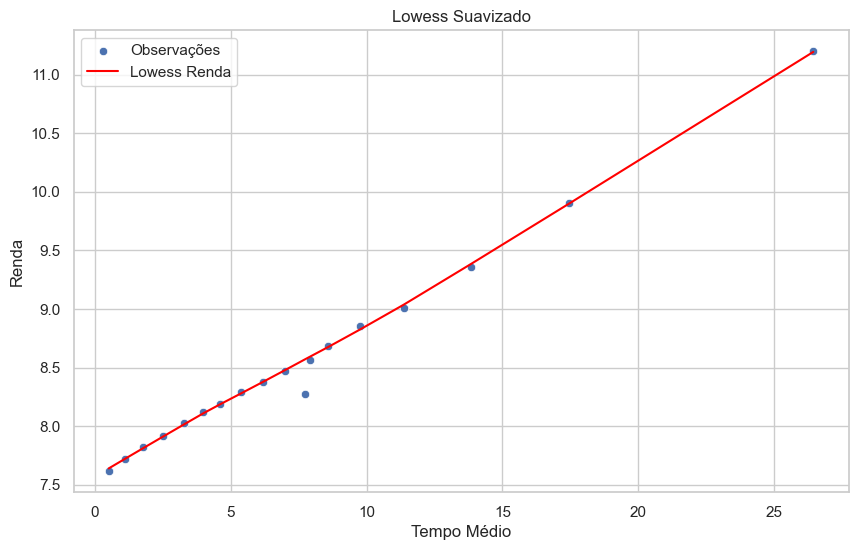

In [157]:
# Criando novo DataFrame com os dados a serem usados
dados = pd.DataFrame({'Tempo Médio': X_selected, 'Renda': y, 'Lowess Renda': y_lowess})

# Estilo do Seaborn
sns.set_style("whitegrid")

# Tamanho da figura
plt.figure(figsize=(10, 6))

# Tipo do gráfico e entrada das variáveis
sns.scatterplot(data=dados, x='Tempo Médio', y='Renda', label='Observações')
# Linha do Lowess
sns.lineplot(data=dados, x='Tempo Médio', y='Lowess Renda', color='red', label='Lowess Renda')

# Legendas
plt.title('Lowess Suavizado')
plt.xlabel('Tempo Médio')
plt.ylabel('Renda')
plt.legend()
plt.show()

In [158]:
# Interpolação do Scipy
f = interp1d(X_selected, y_lowess, bounds_error=False)
df_analise_ultimo_3_meses['Renda Lowess'] = f(df_analise_ultimo_3_meses['tempo_medio'])

In [159]:
df_analise_ultimo_3_meses.head(5)

,q_observacao,media_log_renda,tempo_medio,Renda Lowess
quantis_tempo_emprego,,,,
"(0.11699999999999999, 0.827]",10146,7.615341,0.521711,7.639567
"(0.827, 1.468]",9948,7.721873,1.134223,7.723369
"(1.468, 2.106]",9906,7.825659,1.791140,7.812744
"(2.106, 2.912]",10018,7.920031,2.513849,7.910589
"(2.912, 3.636]",10061,8.023818,3.300750,8.016587


In [160]:
# Ajustando o modelo de regressão
res = smf.ols('y ~ X_selected', data=df_analise_ultimo_3_meses).fit()

# Imprimindo o valor do R-quadrado
print(f'R-quadrado: {res.rsquared:.2%}')

# Visualizando o sumário do modelo
print(res.summary())

R-quadrado: 99.08%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1728.
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           9.89e-18
Time:                        17:22:52   Log-Likelihood:                 19.573
No. Observations:                  18   AIC:                            -35.15
Df Residuals:                      16   BIC:                            -33.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5307      0.032 

C:\Users\Bill_\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


#### O valor de R² deu muito diferente do anterior devido a renda estar dividido em logs da média de cada quantil..

### Lowess sem Log

In [161]:
# Removendo os valores de Lowess anterior
df_analise_ultimo_3_meses.drop(columns = 'Renda Lowess', inplace = True)
df_analise_ultimo_3_meses.columns

Index(['q_observacao', 'media_log_renda', 'tempo_medio'], dtype='object')

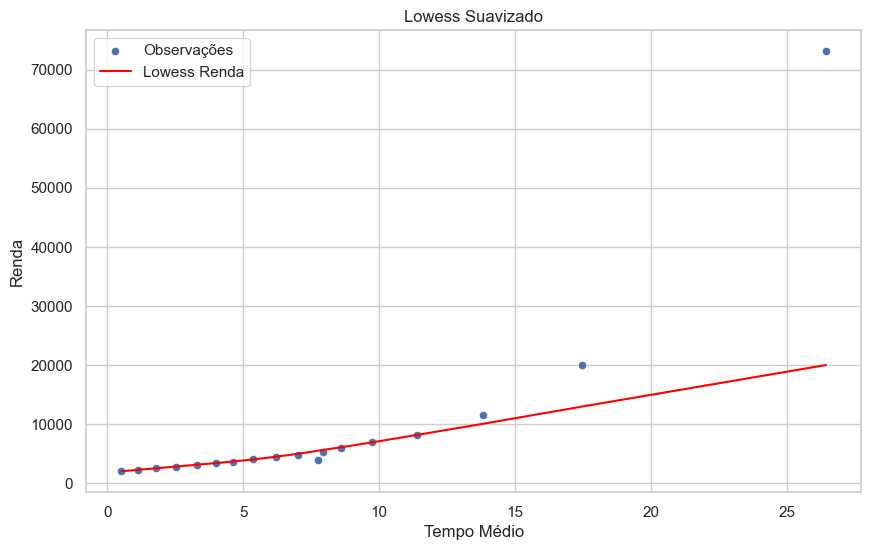

In [162]:
# Criando novos X e y partindo do ultimo DataFrame criado
y = np.exp(df_analise_ultimo_3_meses['media_log_renda'])
X = df_analise_ultimo_3_meses.drop(columns=['media_log_renda'])


# Selecionando uma variável para usar no lowess
X_selected = X['tempo_medio']
# Criando o lowess com fracionamento padrão
lowess = sm.nonparametric.lowess(y, X_selected, frac=2/3)
# Salvando a coluna lowess correspondente ao y
y_lowess = lowess[:, 1]

# Criando novo DataFrame com os dados a serem usados
dados = pd.DataFrame({'Tempo Médio': X_selected, 'Renda': y, 'Lowess Renda': y_lowess})

# Estilo do Seaborn
sns.set_style("whitegrid")

# Tamanho da figura
plt.figure(figsize=(10, 6))

# Tipo do gráfico e entrada das variáveis
sns.scatterplot(data=dados, x='Tempo Médio', y='Renda', label='Observações')
# Linha do Lowess
sns.lineplot(data=dados, x='Tempo Médio', y='Lowess Renda', color='red', label='Lowess Renda')

# Legendas
plt.title('Lowess Suavizado')
plt.xlabel('Tempo Médio')
plt.ylabel('Renda')
plt.legend()
plt.show()

In [163]:
# Interpolação do Scipy
f = interp1d(X_selected, y_lowess, bounds_error=False)
df_analise_ultimo_3_meses['Renda Lowess'] = f(df_analise_ultimo_3_meses['tempo_medio'])

# Ajustando o modelo de regressão
res = smf.ols('y ~ X_selected', data=df_analise_ultimo_3_meses).fit()

# Imprimindo o valor do R-quadrado
print(f'R-quadrado: {res.rsquared:.2%}')

# Visualizando o sumário do modelo
print(res.summary())



R-quadrado: 74.41%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     46.53
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           4.11e-06
Time:                        17:22:53   Log-Likelihood:                -187.56
No. Observations:                  18   AIC:                             379.1
Df Residuals:                      16   BIC:                             380.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7779.0888   3223.349 

C:\Users\Bill_\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


#### Sem os valores em Log o resultado mudou bastante, mas ainda assim ficou bem mais fácil de captar as caracteristicas com os valores divididos em 20 quantis.

#### Para que fique mais próximo a realidade, aumentei a quantidade de quantis para 50 partes e mantive a renda sem usar o logaritimo para verificar o resultado.

In [164]:
# Separando o tempo emprego em 50 quantis
# incluido o duplicates = drop pois estava dando um erro na divisão dos quantis
df_analise_ultimo_3_meses = df_ultimo_3_meses
df_analise_ultimo_3_meses['quantis_tempo_emprego'] = pd.qcut(df_ultimo_3_meses['tempo_emprego'], q = 50, duplicates = 'drop')

# Criando novo DataFrame onde as linhas são os quantis e as colunas são as informações pedidas no exercício
df_analise_ultimo_3_meses = df_ultimo_3_meses.groupby('quantis_tempo_emprego').agg({
    'quantis_tempo_emprego': 'count', # Contagem de observações em cada quantil
    'renda': 'mean', # Média do log da renda
    'tempo_emprego': 'mean' # Média do tempo de emprego
})

# Mudando o nome das colunas
df_analise_ultimo_3_meses.columns = ['q_observacao', 'media_renda', 'tempo_medio']


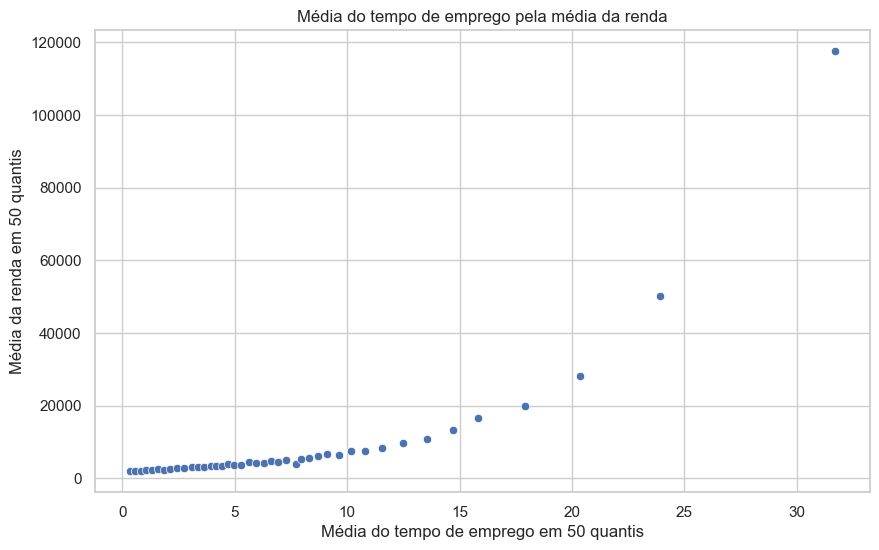

In [165]:
# Estilo do Seaborn
sns.set(style="whitegrid")

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data = df_analise_ultimo_3_meses, x = 'tempo_medio', y = 'media_renda')

# Adicionar título e rótulos
plt.title('Média do tempo de emprego pela média da renda')
plt.xlabel('Média do tempo de emprego em 50 quantis')
plt.ylabel('Média da renda em 50 quantis')

# Exibir o gráfico
plt.show()

### Analise Lowess para 50 quantis

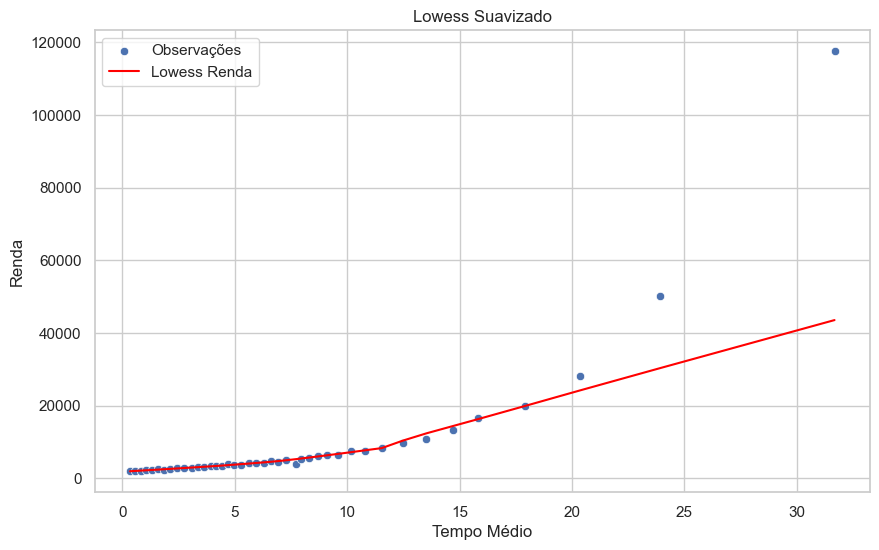

In [166]:
# Criando novos X e y partindo do ultimo DataFrame criado
y = df_analise_ultimo_3_meses['media_renda']
X = df_analise_ultimo_3_meses.drop(columns=['media_renda'])

# Selecionando uma variável para usar no lowess
X_selected = X['tempo_medio']
# Criando o lowess com fracionamento padrão
lowess = sm.nonparametric.lowess(y, X_selected, frac=1/3)
# Salvando a coluna lowess correspondente ao y
y_lowess = lowess[:, 1]

# Criando novo DataFrame com os dados a serem usados
dados = pd.DataFrame({'Tempo Médio': X_selected, 'Renda': y, 'Lowess Renda': y_lowess})

# Estilo do Seaborn
sns.set_style("whitegrid")

# Tamanho da figura
plt.figure(figsize=(10, 6))

# Tipo do gráfico e entrada das variáveis
sns.scatterplot(data=dados, x='Tempo Médio', y='Renda', label='Observações')
# Linha do Lowess
sns.lineplot(data=dados, x='Tempo Médio', y='Lowess Renda', color='red', label='Lowess Renda')

# Legendas
plt.title('Lowess Suavizado')
plt.xlabel('Tempo Médio')
plt.ylabel('Renda')
plt.legend()
plt.show()

#### Fazendo dessa forma, o Lowess já não é capaz de captar os outliers com a fração de 1/3, mas se aumentar essa fração pode acarretar em overfitting para dados futuros.

### Modelo segmentado

In [167]:
# Definindo os pontos de quebra para a segmentação
C1 = 8
C2 = 15

# Criando as variáveis segmentadas
df_analise_ultimo_3_meses['X1_1'] = (df_analise_ultimo_3_meses['tempo_medio'] <= C1) * df_analise_ultimo_3_meses['tempo_medio'] + (df_analise_ultimo_3_meses['tempo_medio'] > C1) * C1
df_analise_ultimo_3_meses['X1_2'] = (df_analise_ultimo_3_meses['tempo_medio'] <= C1) * 0 + ((df_analise_ultimo_3_meses['tempo_medio'] > C1) & (df_analise_ultimo_3_meses['tempo_medio'] <= C2)) * (df_analise_ultimo_3_meses['tempo_medio'] - C1) + (df_analise_ultimo_3_meses['tempo_medio'] > C2) * (C2 - C1)
df_analise_ultimo_3_meses['X1_3'] = (df_analise_ultimo_3_meses['tempo_medio'] <= C2) * 0 + (df_analise_ultimo_3_meses['tempo_medio'] > C2) * (df_analise_ultimo_3_meses['tempo_medio'] - C2)

# Definindo as variáveis dependentes e independentes
x = df_analise_ultimo_3_meses[['X1_1', 'X1_2', 'X1_3']]
y = df_analise_ultimo_3_meses['media_renda']

# Ajustando o modelo de regressão
model = sm.OLS(y, x).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            media_renda   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              511.3
Date:                Thu, 29 Feb 2024   Prob (F-statistic):                    2.46e-31
Time:                        17:22:54   Log-Likelihood:                         -400.34
No. Observations:                  42   AIC:                                      806.7
Df Residuals:                      39   BIC:                                      811.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

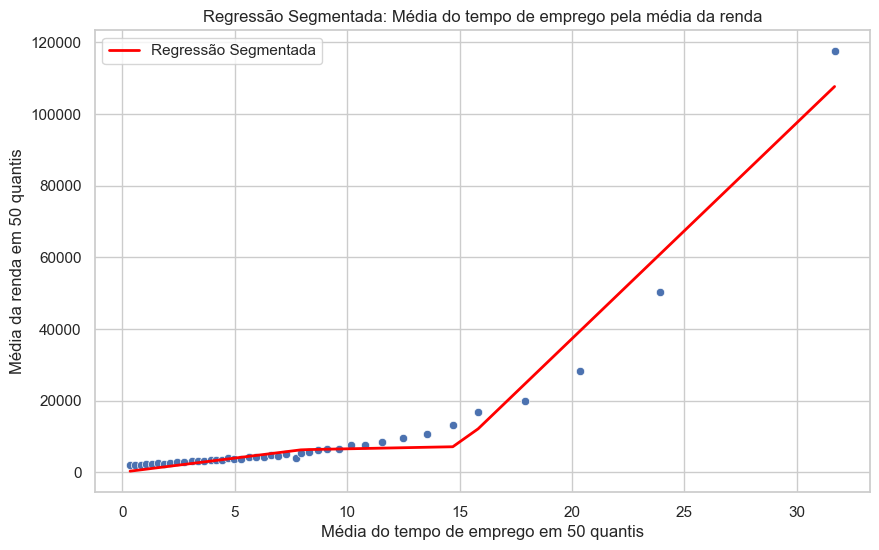

In [168]:
# Estilo do Seaborn
sns.set(style="whitegrid")

# Tamanho do gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_analise_ultimo_3_meses, x='tempo_medio', y='media_renda')

# Linhas de regressão segmentada
plt.plot(df_analise_ultimo_3_meses['tempo_medio'], model.predict(df_analise_ultimo_3_meses[['X1_1', 'X1_2', 'X1_3']]), color='red', linewidth=2, label='Regressão Segmentada')

# Título e rótulos
plt.title('Regressão Segmentada: Média do tempo de emprego pela média da renda')
plt.xlabel('Média do tempo de emprego em 50 quantis')
plt.ylabel('Média da renda em 50 quantis')

# legenda
plt.legend()

plt.show()

In [169]:
# Definindo os pontos de quebra para a segmentação
C1 = 14
C2 = 20

# Criando as variáveis segmentadas
df_analise_ultimo_3_meses['X1_1'] = (df_analise_ultimo_3_meses['tempo_medio'] <= C1) * df_analise_ultimo_3_meses['tempo_medio'] + (df_analise_ultimo_3_meses['tempo_medio'] > C1) * C1
df_analise_ultimo_3_meses['X1_2'] = (df_analise_ultimo_3_meses['tempo_medio'] <= C1) * 0 + ((df_analise_ultimo_3_meses['tempo_medio'] > C1) & (df_analise_ultimo_3_meses['tempo_medio'] <= C2)) * (df_analise_ultimo_3_meses['tempo_medio'] - C1) + (df_analise_ultimo_3_meses['tempo_medio'] > C2) * (C2 - C1)
df_analise_ultimo_3_meses['X1_3'] = (df_analise_ultimo_3_meses['tempo_medio'] <= C2) * 0 + (df_analise_ultimo_3_meses['tempo_medio'] > C2) * (df_analise_ultimo_3_meses['tempo_medio'] - C2)

# Definindo as variáveis dependentes e independentes
x = df_analise_ultimo_3_meses[['X1_1', 'X1_2', 'X1_3']]
y = df_analise_ultimo_3_meses['media_renda']

# Ajustando o modelo de regressão
model = sm.OLS(y, x).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            media_renda   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              4220.
Date:                Thu, 29 Feb 2024   Prob (F-statistic):                    5.09e-49
Time:                        17:22:54   Log-Likelihood:                         -356.48
No. Observations:                  42   AIC:                                      719.0
Df Residuals:                      39   BIC:                                      724.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

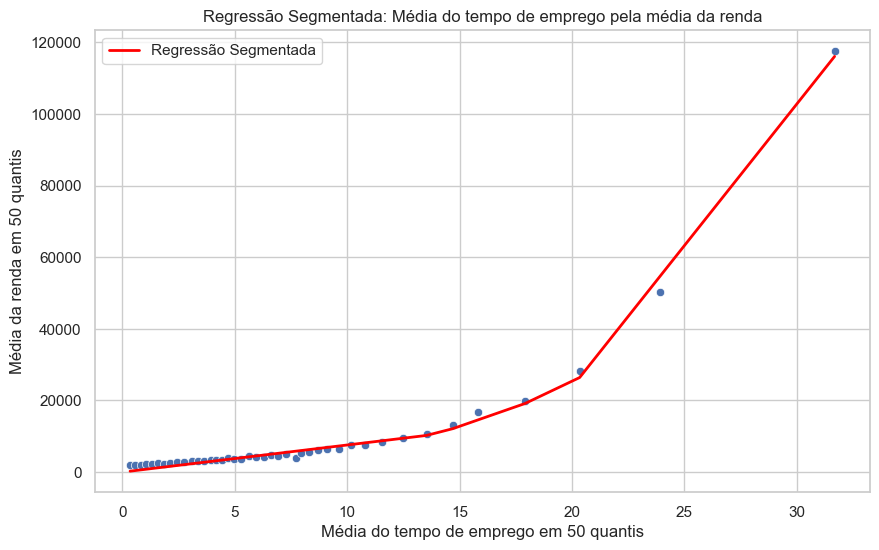

In [170]:
# Estilo do Seaborn
sns.set(style="whitegrid")

# Tamanho do gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_analise_ultimo_3_meses, x='tempo_medio', y='media_renda')

# Linhas de regressão segmentada
plt.plot(df_analise_ultimo_3_meses['tempo_medio'], model.predict(df_analise_ultimo_3_meses[['X1_1', 'X1_2', 'X1_3']]), color='red', linewidth=2, label='Regressão Segmentada')

# Título e rótulos
plt.title('Regressão Segmentada: Média do tempo de emprego pela média da renda')
plt.xlabel('Média do tempo de emprego em 50 quantis')
plt.ylabel('Média da renda em 50 quantis')

# legenda
plt.legend()

plt.show()

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

Ambos os modelos se sairam bem, o Lowess é melhor em situações onde há pouca alteração dos dados e a segmentação faz o contrário, parece que se da melhor em situações onde há uma alteração mais drastica dos valores, por isso é legal de usar o Lowess com uma transformação de dados.

Os dois métodos podem ter problemas com overfitting, o Lowess ao deixar adaptar demais, colocando um denominador muito alto em seu hyperparametro e a segmentação ao fazer muitas quebras, nos dois casos podem ter problemas ao se deparar com dados não vistos.